## Mount to current working directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Audio_proj

%pip install pandas
%pip install numpy
%pip install scipy
%pip install sklearn
%pip install matplotlib
%pip install torch
%pip install transformers
%pip install joblib
%pip install xlsxwriter

Mounted at /content/drive
/content/drive/My Drive/Audio_proj
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.0 MB/s eta 0:00:00


## Unzip training, validation and test files

In [ ]:
!unzip train_5000.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_5000/o_fickle_fortune-a_celebration_of_robert_burns-05-thine_i_am-0-29.wav  
  inflating: train_5000/kyiv_chamber_choir-praise_the_lord-02-rachmaninovbless_the_lord_o_my_soul-117-146.wav  
  inflating: train_5000/ensemble_sreteniye-ancient_church_singing_of_byzantine_georgia_and_rus-02-psalm_146_and_o_thou_the_only_begotten_son-88-117.wav  
  inflating: train_5000/american_bach_soloists-j_s__bach_solo_cantatas-13-bwv55__v_chorale-30-59.wav  
  inflating: train_5000/farallon_recorder_quartet-ludwig_senfl-13-ecce_quam_bonum-0-29.wav  
  inflating: train_5000/mercy_machine-the_devil_i_know-09-the_man_i_create-146-175.wav  
  inflating: train_5000/mercy_machine-in_your_bed-05-adam_undivided-30-59.wav  
  inflating: train_5000/human_response-survival-07-distance-146-175.wav  
  inflating: train_5000/paul_avgerinos-maya__the_great_katun-08-night_of_the_goddess_part_4-88-117.wav  
  inflating: train_5000/four_stones-chronic

In [ ]:
!unzip valid.zip


Archive:  valid.zip
   creating: valid/
  inflating: valid/the_strap_ons-geeking_crime-03-promo_mom-0-29.wav  
  inflating: valid/tanya_tomkins_and_eric_zivian-beethoven_piano_and_cello_works-09-11_bagatelles_for_solo_fortepiano_op__119_no__6-59-88.wav  
  inflating: valid/the_west_exit-nocturne-11-all_right_now-204-233.wav  
  inflating: valid/the_art_of_the_lute_player-the_art_of_the_lute_player-14-pavan_heres_paternus__antony_holborne__jacob_heringman-262-291.wav  
  inflating: valid/tanya_tomkins_and_eric_zivian-beethoven_piano_and_cello_works-03-7_variations_on_a_theme_from_the_magic_flute_in_eb_woo_46-320-349.wav  
  inflating: valid/the_wretch-ambulatory-15-release-117-146.wav  
  inflating: valid/the_sarasa_ensemble-a_baroque_mosaic-20-cantata_il_delirio_amoroso__aria_handel-0-29.wav  
  inflating: valid/the_west_exit-nocturne-09-interlude_2-88-117.wav  
  inflating: valid/the_sarasa_ensemble-a_baroque_mosaic-05-partia_no_5__passacaglia_biber-88-117.wav  
  inflating: valid/the

In [ ]:
!unzip test.zip

Archive:  test.zip
   creating: test/
  inflating: __MACOSX/._test         
  inflating: test/utopia_banished-night_of_the_black_wyvern-07-voice_of_disharmony-59-88.wav  
  inflating: test/touchinggrace-happenstance-11-eastern_sky-175-204.wav  
  inflating: test/zilla-egg-10-a_bakers_dozen-204-233.wav  
  inflating: test/version-versions-09-oh_no_again-146-175.wav  
  inflating: test/various_artists-south_by_southwest_compilation-09-and_come_the_sirens_jade_leary-204-233.wav  
  inflating: test/williamson-a_few_things_to_hear_before_we_all_blow_up-03-raining_at_the_crescent_house-204-233.wav  
  inflating: test/voices_of_music-an_evening_with_bach-12-kein_artz_bwv_103-88-117.wav  
  inflating: test/version-versions-01-double_trust-117-146.wav  
  inflating: test/voices_of_music-an_evening_with_bach-15-passacaglia_mein_freund_ist_mein_j_c__bach-436-465.wav  
  inflating: test/various_artists-the_art_of_persuasion-05-follow_your_bliss_paul_avgerinos-291-320.wav  
  inflating: test/vito_p

## Set Seed to ensure reproducibility

In [ ]:
import random
import torch
import numpy as np

def set_seed(seed_value=42):
    """Set seed for reproducibility for PyTorch and NumPy.

    Args:
        seed_value (int): The seed value to set for random number generators.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

    # Additional steps for deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42)  # You can replace 42 with any other seed value of your choice

## Create a Dataset class that returns audio embeddings (using wav2vec) and labels (as tensors)

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import librosa
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import joblib
import os

#import wav2vec model and processor
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

class CustomAudioDataset(Dataset):
    def __init__(self, csv_path, processor, apply_pca=False, desired_output_size=None, pca_subset_size=None, pca_model_path=None):
        self.dataframe = pd.read_csv(csv_path)
        self.processor = processor
        self.apply_pca = apply_pca
        self.desired_output_size = desired_output_size
        self.pca_subset_size = pca_subset_size

        # Extract column names for labels dynamically
        self.label_columns = list(self.dataframe.columns[:-1])  # Exclude first two columns since these are irrelevant

        # Initialize PCA if apply_pca is True
        if self.apply_pca:
            # Use a subset for PCA fitting if specified
            if self.pca_subset_size is not None:
                train_df, _ = train_test_split(self.dataframe, train_size=self.pca_subset_size, random_state=42) #randomized selection of data
            else:
                train_df = self.dataframe

            # Extract embeddings from the subset of the training dataset
            train_embeddings = []
            for idx in range(len(train_df)):
                audio_path = train_df.iloc[idx]['mp3_path']
                audio_data, _ = librosa.load(audio_path, sr=16000, mono=True, res_type="kaiser_fast")
                input_tensors = self.processor(audio_data, return_tensors="pt", sampling_rate=16000).input_values
                train_embeddings.append(input_tensors.flatten().numpy())

            # Convert the list of embeddings to a NumPy array
            train_embeddings = np.array(train_embeddings)

            # Initialize PCA and fit it on the training embeddings
            self.pca = PCA(n_components=self.desired_output_size)
            self.pca.fit(train_embeddings)

            # Save the PCA model with subset size in the file path
        if pca_model_path is not None:
            print(f"Saving or loading PCA model from: {pca_model_path}")
            if self.apply_pca:
                print(f"Saving PCA model to: {pca_model_path}")
                self.save_pca_model(pca_model_path)
            else:
                print(f"Loading PCA model from: {pca_model_path}")
                self.pca = joblib.load(pca_model_path)

        else:
           self.pca = None #Set to None when PCA should not be applied

    def __len__(self):
        return len(self.dataframe)

    def save_pca_model(self, pca_model_path):
      # Save the PCA model to the specified path
      joblib.dump(self.pca, pca_model_path)

    def apply_pca_to_embeddings(self, embeddings):
        if self.apply_pca:
            embeddings_flatten = embeddings.flatten()
            embeddings_pca = self.pca.transform(embeddings_flatten.reshape(1, -1)).flatten()
            return torch.tensor(embeddings_pca, dtype=torch.float32)
        else:
            return embeddings.squeeze()

    def __getitem__(self, idx):
        # Get the audio path
        audio_path = self.dataframe.iloc[idx]['mp3_path']

        # Select label columns based on the dynamically created list. This is grabbing all 188 class label names and converting to tensors.
        labels_array = self.dataframe.iloc[idx].loc[self.label_columns].astype('float').values
        labels = torch.tensor(labels_array, dtype=torch.float32)

        # Load raw audio data using librosa
        audio_data, _ = librosa.load(audio_path, sr=16000, mono=True, res_type="kaiser_fast")

        # Use processor to process audio file and return tensor of input values for model
        input_tensors = self.processor(audio_data, return_tensors="pt", sampling_rate=16000).input_values

        if self.apply_pca:
            # Apply PCA to the embeddings
            input_tensors_pca = self.apply_pca_to_embeddings(input_tensors)

            return input_tensors_pca, labels
        else:
            # Use the loaded PCA model to transform the embeddings
            input_tensors_pca = self.pca.transform(input_tensors.flatten().numpy().reshape(1, -1)).flatten()
            return torch.tensor(input_tensors_pca, dtype=torch.float32), labels

    # Define collate_fn to handle the varying lengths of audio files and labels. This will help with batching.
    def collate_fn(self, batch):
        input_tensors_batch, labels_batch = zip(*batch)
        return torch.stack(input_tensors_batch), torch.stack(labels_batch)


config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:381: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'lm_head.weight', 'lm_head.bias', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

## Generate training, validation and test datasets with PyTorch Dataset

### Uncomment and run this code chunk if you want to create new instances of the CustomAudioDataset with different parameters

* Uncomment and change number of principal components (desired_output_size), the number of samples to use to generate the principal components (pca_subset_size, where None = all samples), and to specifiy which csv to use (csv_path_train) and the name of the saved model (pcs_model_path_).

* This can be done for any of the datasets.
* If you want to load a saved model, skip this chunk and leave it commented out.








In [ ]:
# Desired_output_size == number of PCAs and pca_subset_size == number of examples used to generate PCAs.
# These will be saved as 'pca_model_train_subset{number_of_examples}. If pca_subset_size == None, the instance will use all of the available data from the file.

# csv_path_train = 'train_5000_example.csv'
# pca_model_path_train = 'pca_model_train'
# train_example = CustomAudioDataset(csv_path=csv_path_train, processor=processor, apply_pca=True, desired_output_size=500, pca_subset_size=None, pca_model_path=pca_model_path_train)

# csv_path_val = 'valid_example.csv'
# pca_model_path_val = 'pca_model_valid'
# val_example = CustomAudioDataset(csv_path=csv_path_val, processor=processor, apply_pca=True, desired_output_size=500, pca_subset_size=None, pca_model_path=pca_model_path_val)

# csv_path_test = 'test_example.csv'
# pca_model_path_test = 'pca_model_test'
# test_example = CustomAudioDataset(csv_path=csv_path_test, processor=processor, apply_pca=True, desired_output_size=500, pca_subset_size=None, pca_model_path=pca_model_path_test)

Saving or loading PCA model from: pca_model_test
Saving PCA model to: pca_model_test


### Training Data - Loading saved PCA model and creating a dataset with the reduced embeddings and labels

In [ ]:
# Example usage
csv_path_train = 'train_5000_example.csv'
pca_model_path_train = 'pca_model_train_subsetNone.joblib'
train_example = CustomAudioDataset(csv_path=csv_path_train, processor=processor, apply_pca=False, desired_output_size=None, pca_subset_size=None, pca_model_path=pca_model_path_train)

#set the batch size for all dataloaders
batch_size = 32

#Dataloader for training
train_loader = DataLoader(train_example, batch_size=batch_size, shuffle=True, collate_fn=train_example.collate_fn)

#get the size of the audio embeddings
input_size = train_loader.dataset[0][0].shape[0] #make sure that we can easily modify embedding size input to model

#Check the size of the datasets and the audio embeddings
print(f'We have {len(train_example)} training examples')
print(f'The size of our audio embeddings is {input_size}.')
print(f'The number of labels is {train_loader.dataset[0][1].size(0)}')

Saving or loading PCA model from: pca_model_train_subsetNone.joblib
Loading PCA model from: pca_model_train_subsetNone.joblib
We have 5000 training examples
The size of our audio embeddings is 500.
The number of labels is 188


### Validation Data - Loading saved PCA model and creating a dataset with the reduced embeddings and labels

In [ ]:
# Example usage
csv_path_val = 'valid_example.csv'
pca_model_path_val = 'pca_model_train_subsetNone.joblib'
val_example = CustomAudioDataset(csv_path=csv_path_val, processor=processor, apply_pca=False, desired_output_size=None, pca_subset_size=None, pca_model_path=pca_model_path_val)

#set the batch size for all dataloaders
batch_size = 32

#Dataloader for training
val_loader = DataLoader(val_example, batch_size=batch_size, shuffle=False, collate_fn=val_example.collate_fn)

#get the size of the audio embeddings
input_size_val = val_loader.dataset[0][0].shape[0] #make sure that we can easily modify embedding size input to model

#Check the size of the datasets and the audio embeddings
print(f'We have {len(val_example)} training examples')
print(f'The size of our audio embeddings is {input_size_val}.')
print(f'The number of labels is {train_loader.dataset[0][1].size(0)}')

Saving or loading PCA model from: pca_model_train_subsetNone.joblib
Loading PCA model from: pca_model_train_subsetNone.joblib
We have 1293 training examples
The size of our audio embeddings is 500.
The number of labels is 188


### Test Data - Loading saved PCA model and creating a dataset with the reduced embeddings and labels

In [ ]:
# Example usage
csv_path_test = 'test_example.csv'
pca_model_path_test = 'pca_model_test'
test_example = CustomAudioDataset(csv_path=csv_path_test, processor=processor, apply_pca=False, desired_output_size=None, pca_subset_size=None, pca_model_path=pca_model_path_test)

#set the batch size for all dataloaders
batch_size = 32

#Dataloader for training
test_loader = DataLoader(test_example, batch_size=batch_size, shuffle=False, collate_fn=test_example.collate_fn)

#get the size of the audio embeddings
input_size_test = test_loader.dataset[0][0].shape[0] #make sure that we can easily modify embedding size input to model

#Check the size of the datasets and the audio embeddings
print(f'We have {len(test_example)} test examples')
print(f'The size of our audio embeddings is {input_size_test}.')
print(f'The number of labels is {test_loader.dataset[0][1].size(0)}')

Saving or loading PCA model from: pca_model_test
Loading PCA model from: pca_model_test
We have 2586 test examples
The size of our audio embeddings is 500.
The number of labels is 188


### Checking all data before passing to model

In [ ]:
#Check the size of the datasets and the audio embeddings
print(f'We have {len(train_example)} training examples, {len(val_example)} validation examples, and {len(test_example)} test examples.')
print(f'We have {len(train_loader)} batches in the training set, {len(val_loader)} batches in the validation set, and {len(test_loader)} batches in the test set.')
print(f'The size of our audio embeddings is {input_size} for training, {input_size_val} validation, and {input_size_test} for test.')

We have 5000 training examples, 1293 validation examples, and 2586 test examples.
We have 157 batches in the training set, 41 batches in the validation set, and 81 batches in the test set.
The size of our audio embeddings is 500 for training, 500 validation, and 500 for test.


## Model Architecture: Custom FFNN with two layers, ReLU activation, Dropout, and Sigmoid (loss function)

In [ ]:
# Update if we want to make it deeper etc.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CustomAudioModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_classes, dropout_rate=0.5):
        super(CustomAudioModel, self).__init__()

        # Define custom feed-forward layers with decreasing hidden sizes
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.fc3 = nn.Linear(output_size, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, embeddings):
        # Apply custom feed-forward layers directly to the input_values
        x = self.fc1(embeddings)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        # Remove extra dimension
        x = x.squeeze(1)

        return x

## Training, Validating and Testing with Unseen Data

### Addressing Class Imbalance in Train, Val, Test data by passing new weights into Loss Functions

In [ ]:
# Function to generate class weights to be applied to the minority class ('1') in each label column to address class imbalance.

def class_weights(data_df):
    class_weights = []
    total_samples = len(data_df)

    for col in data_df.columns:
        class_counts = data_df[col].sum()
        if class_counts == 0:
            imbalance_ratio = 1.0 #if there are no positive samples, set imbalance ratio to 1
        else:
            imbalance_ratio = (total_samples - class_counts) / class_counts #calculate imbalance ratio. This is the ratio of negative to positive samples.
        class_weights.append(torch.tensor([1.0, imbalance_ratio], dtype=torch.float32)) #append to list of class weights
    class_weights_tensor = torch.tensor([weight[1] for weight in class_weights], dtype=torch.float32).unsqueeze(0) #extract the second value of each tensor in the list since this is the minority class weight. Then convert to tensor.
    return class_weights_tensor

#In training data, generate weights specific to label column distribution to apply to each of the 188 labels to account for class imbalance.
train_df = pd.read_csv('train_5000_example.csv')
train_df = train_df.drop(['mp3_path'], axis=1)
train_weights_balanced = class_weights(train_df)
print(f"We have {(train_weights_balanced.shape[1])} labels in our training set. The updated weights for the minority label ('1') within each column are: ", train_weights_balanced)

#In validation data, generate weights specific to label column distribution to apply to each of the 188 labels to account for class imbalance.
val_df = pd.read_csv('valid_example.csv')
val_df = val_df.drop(['mp3_path'], axis=1)
val_weights_balanced = class_weights(val_df)
print(f"We have {(val_weights_balanced.shape[1])} labels in our validation set. The updated weights for the minority label ('1') within each column are: ", val_weights_balanced)

#In test data, generate weights specific to label column distribution to apply to each of the 188 labels to account for class imbalance.
test_df = pd.read_csv('test_example.csv')
test_df = test_df.drop(['mp3_path'], axis=1)
test_weights_balanced = class_weights(test_df)
print(f"We have {(test_weights_balanced.shape[1])} labels in our test set. The updated weights for the minority label ('1') within each column are: ", test_weights_balanced)


We have 188 labels in our training set. The updated weights for the minority label ('1') within each column are:  tensor([[  45.7290,  177.5714,  453.5454,  499.0000,   95.1538,  332.3333,
          624.0000,   19.0000,  311.5000, 1249.0000,   34.9712,  160.2903,
          453.5454,   28.7619,   22.3645,  499.0000,  130.5789,  332.3333,
           36.3134,  383.6154, 2499.0000,  134.1351,  499.0000,  311.5000,
           82.3333,   83.7458,  383.6154,    4.7803,   14.9236,  554.5555,
          499.0000,  624.0000,  146.0588,   63.9351,    4.3763,   24.0000,
          311.5000,  107.6957,  105.3830,   32.1126,   69.4225,   97.0392,
           48.5050,  226.2727,  713.2857,   10.6009,   32.7838,   12.0890,
          249.0000,  191.3077,  171.4138,  554.5555,  137.8889,   56.4713,
          293.1176,   36.0370,  276.7778,  237.0952,  276.7778,    8.4877,
           69.4225,   69.4225,   99.0000,   39.3226,  383.6154,  311.5000,
          155.2500,   24.5102,   35.7647,   91.5926,    9.615

## To access a previously trained model and skip training:

*   Run the below code chunks to access a saved model. Do not run training loop chunk.
*   If not accessing a saved model, skip these chunks and run the training loop chunk



In [ ]:
#Setting hyperparameters to load saved model.

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

#hyperparmeters
hidden_size=300
output_size= 200 #this is the size of the hidden layer output from first feed-forward layer
num_classes=188 #this is the number of labels we have
dropout_rate=0.75 #this is the dropout rate for the dropout layer
criterion_train = nn.BCEWithLogitsLoss(pos_weight=train_weights_balanced) #use this loss function since we are doing multilabel classification. pos_weight is the weight to apply to the minority class ('1') in each label column to address class imbalance.
weight_decay = .01 #this is the L2 regularization weight decay
optimizer = optim.Adam(model.parameters(), lr=.1, weight_decay=weight_decay) #use Adam optimizer with learning rate of .01, and L2 regularization with weight decay of 1e-5
num_epochs = 10 #number of epochs before convergence
scheduler = StepLR(optimizer, step_size=2, gamma=0.1) #adjusts learning rate during training. Step size indicates the number of epochs after which the learning rate should be adjusted by gamma. Gamma is a factor by which the LR is adjusted, beginning with LR=.001

In [ ]:
# Create an instance of your model
model = CustomAudioModel(input_size, hidden_size=hidden_size, output_size=output_size, num_classes=num_classes, dropout_rate=dropout_rate)

# Load the saved model state dictionary
model_path = "./model_5000N"
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()

CustomAudioModel(
  (fc1): Linear(in_features=500, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=188, bias=True)
  (dropout): Dropout(p=0.75, inplace=False)
)

In [ ]:
# Print the number of parameters for each layer

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel()}")


fc1.weight: 150000
fc1.bias: 300
fc2.weight: 60000
fc2.bias: 200
fc3.weight: 37600
fc3.bias: 188


## Training Loop - do not run this if you are loading an already saved model

* Initialize Model
* Specify hyperparameters
* Train the model and print the loss





In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

#hyperparmeters

hidden_size=300
output_size= 200 #this is the size of the hidden layer output from first feed-forward layer
num_classes=188 #this is the number of labels we have
dropout_rate=0.75 #this is the dropout rate for the dropout layer
criterion_train = nn.BCEWithLogitsLoss(pos_weight=train_weights_balanced) #use this loss function since we are doing multilabel classification. pos_weight is the weight to apply to the minority class ('1') in each label column to address class imbalance.
weight_decay = .01 #this is the L2 regularization weight decay
optimizer = optim.Adam(model.parameters(), lr=.1, weight_decay=weight_decay) #use Adam optimizer with learning rate of .1, and L2 regularization with weight decay of .01
num_epochs = 10 #number of epochs before convergence
scheduler = StepLR(optimizer, step_size=2, gamma=0.1) #adjusts learning rate during training. Step size indicates the number of epochs after which the learning rate should be adjusted by gamma. Gamma is a factor by which the LR is adjusted, beginning with LR=.001

#initialize model
model = CustomAudioModel(input_size, hidden_size=hidden_size, output_size=output_size, num_classes=num_classes, dropout_rate=dropout_rate)

# Lists to store training loss values and epoch numbers
train_losses = []
train_epochs = []

#training loop
for epoch in range(num_epochs):
    model.train()
    total_gradients = 0

    for batch_idx, batch in enumerate(train_loader):
        embeddings, labels = batch
        #embeddings, labels = embeddings.to(device), labels.to(device)
        outputs = model(embeddings)
        #print(f"Batch Index: {batch_idx}, Embeddings Shape: {embeddings.shape}, Labels Shape: {labels.shape}")
        # print("Input shape:", embeddings.shape)
        # print("Labels shape:", labels.shape)
        #print("Output shape:", outputs.shape)
        loss = criterion_train(outputs, labels)
        optimizer.zero_grad()
        loss.backward()

        # Accumulate gradients for each parameter
        for name, param in model.named_parameters():
            if param.grad is not None:
              total_gradients += param.grad.mean().item()

        optimizer.step() #update optimizer

        scheduler.step() #use scheduler to adjust learning rate (Adam optimizer) after every 2 epochs

        # Calculate the average gradient across all batches
        avg_gradient = total_gradients / len(train_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Average Gradient: {avg_gradient}, Loss: {loss.item()}")


Epoch 1/10, Average Gradient: 0.02583667065996624, Loss: 5.437987804412842
Epoch 2/10, Average Gradient: 0.07711035497443208, Loss: 2.7893130779266357
Epoch 3/10, Average Gradient: 0.1281263184383044, Loss: 2.9013240337371826
Epoch 4/10, Average Gradient: 0.1788522100452941, Loss: 4.009814739227295
Epoch 5/10, Average Gradient: 0.2300861568185428, Loss: 2.7438976764678955
Epoch 6/10, Average Gradient: 0.2815121102954821, Loss: 3.3594138622283936
Epoch 7/10, Average Gradient: 0.33285410784262276, Loss: 3.105936288833618
Epoch 8/10, Average Gradient: 0.38358953913019506, Loss: 3.9498813152313232
Epoch 9/10, Average Gradient: 0.4343358659275342, Loss: 6.392364978790283
Epoch 10/10, Average Gradient: 0.48527440848196857, Loss: 3.990352153778076


### Validation Loop - Loss Profile and Overall Evaluation Metrics

Epoch 1/10, Validation Loss: 56.63807713985443
Epoch 2/10, Validation Loss: 56.63807713985443
Epoch 3/10, Validation Loss: 56.63807713985443
Epoch 4/10, Validation Loss: 56.63807713985443
Epoch 5/10, Validation Loss: 56.63807713985443
Epoch 6/10, Validation Loss: 56.63807713985443
Epoch 7/10, Validation Loss: 56.63807713985443
Epoch 8/10, Validation Loss: 56.63807713985443
Epoch 9/10, Validation Loss: 56.63807713985443
Epoch 10/10, Validation Loss: 56.63807713985443
Overall Validation Accuracy: 51.0%, Validation Precision: 0.01869119623655914, Validation Recall: 0.48527808069792805, Validation F1: 0.03599595551061678
Classification Report:
{'no voice': {'precision': 0.018410852713178296, 'recall': 0.8260869565217391, 'f1-score': 0.03601895734597156, 'support': 230}, 'singer': {'precision': 0.01, 'recall': 0.3333333333333333, 'f1-score': 0.019417475728155338, 'support': 30}, 'duet': {'precision': 0.0008025682182985554, 'recall': 1.0, 'f1-score': 0.0016038492381716118, 'support': 10}, 'p

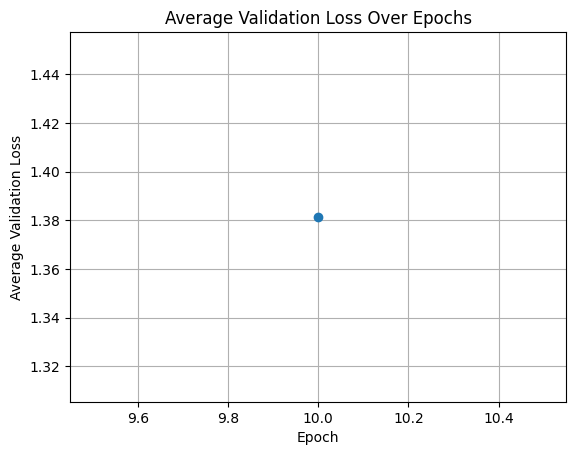

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, multilabel_confusion_matrix

criterion_val = nn.BCEWithLogitsLoss(pos_weight=val_weights_balanced) #use this loss function since we are doing multilabel classification. pos_weight is the weight to apply to the minority class ('1') in each label column to address class imbalance.
correct_predictions = 0
total_samples = 0
val_pred = []
val_true = []

for epoch in range(num_epochs):
    val_loss = 0
    with torch.no_grad():
        for val_batch in val_loader:
            embeddings_val, labels_val = val_batch

            # Forward pass (no optimization in validation)
            val_outputs = model(embeddings_val)

            # Compute validation loss
            loss = criterion_val(val_outputs, labels_val)
            val_loss += loss.item()

            #Convert probabilities to binary predictions using a threshold of 0.5
            predictions = (torch.sigmoid(val_outputs) > 0.5).float()

            #Collect predictions and true labels for precision, recall and F1 score
            val_pred.append(predictions.cpu().numpy())
            val_true.append(labels_val.cpu().numpy())

            #Compute validation accuracy
            correct_predictions += (predictions == labels_val).sum().item()
            total_samples += labels_val.numel()
            # Print validation loss after each epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss}")

# Calculate average validation loss
avg_val_loss = val_loss / len(val_loader)

#Concatenate predictions and true labels along the sample axis
val_pred = np.concatenate(val_pred, axis=0)
val_true = np.concatenate(val_true, axis=0)

#Calculate overall validation accuracy
val_accuracy = round(((correct_predictions / total_samples)*100), 1)

#Compute precision, recall and F1 score
precision = precision_score(val_true, val_pred, average='micro') #micro is used to account for class imbalance
recall = recall_score(val_true, val_pred, average='micro') #micro is used to account for class imbalance
f1 = f1_score(val_true, val_pred, average='micro') #micro is used to account for class imbalance

#compute confusion matrix for each label

conf_matrix_val = multilabel_confusion_matrix(val_true, val_pred)

# Print validation metrics after each epoch
print(f"Overall Validation Accuracy: {val_accuracy}%, Validation Precision: {precision}, Validation Recall: {recall}, Validation F1: {f1}")

# Compute classification report

data = pd.read_csv('train_5000_example.csv')
label_names = data.columns[:-1].tolist()

class_report = classification_report(val_true, val_pred, target_names=label_names, zero_division=1, output_dict=True)

# Print classification report
print("Classification Report:")
print(class_report)

#Save model
model_path = "./model_5000N"
torch.save(model.state_dict(), model_path)

### Printing and Exporting Validation Evaluation Metrics to further look into latent trends

In [ ]:
# Calculate the average precision, recall, and f1-score
avg_precision = sum(class_report[label]['precision'] for label in label_names) / len(label_names)
avg_recall = sum(class_report[label]['recall'] for label in label_names) / len(label_names)
avg_f1 = sum(class_report[label]['f1-score'] for label in label_names) / len(label_names)

# Identify classes that are above their respective averages
above_avg_precision = [label for label in label_names if class_report[label]['precision'] > avg_precision]
above_avg_recall = [label for label in label_names if class_report[label]['recall'] > avg_recall]
above_avg_f1 = [label for label in label_names if class_report[label]['f1-score'] > avg_f1]

# Create a dictionary with the average values
avg_dict = {
    'Metric': ['Precision', 'Recall', 'F1-Score'],
    'Average': [avg_precision, avg_recall, avg_f1]
}

# Create a DataFrame from the average dictionary
avg_df = pd.DataFrame(avg_dict)

# Print the average DataFrame
print("Average Metrics:")
print(avg_df)

# Identify classes that are above their respective averages
above_avg_precision = [label for label in label_names if class_report[label]['precision'] > avg_precision]
above_avg_recall = [label for label in label_names if class_report[label]['recall'] > avg_recall]
above_avg_f1 = [label for label in label_names if class_report[label]['f1-score'] > avg_f1]

# Create a dictionary with the class-specific metrics
class_metrics_dict = {
    'Class': label_names,
    'Precision': [class_report[label]['precision'] for label in label_names],
    'Recall': [class_report[label]['recall'] for label in label_names],
    'F1-Score': [class_report[label]['f1-score'] for label in label_names],
    'Support': [class_report[label]['support'] for label in label_names]
}

# Create a DataFrame from the class-specific metrics dictionary
class_metrics_df = pd.DataFrame(class_metrics_dict)

# Print the class-specific metrics DataFrame
print("\nClass-Specific Metrics:")
print(class_metrics_df)

# Filter classes based on whether their precision, recall, or f1-score is above average
above_avg_precision_df = class_metrics_df[class_metrics_df['Class'].isin(above_avg_precision)]
above_avg_recall_df = class_metrics_df[class_metrics_df['Class'].isin(above_avg_recall)]
above_avg_f1_df = class_metrics_df[class_metrics_df['Class'].isin(above_avg_f1)]

# Print the filtered DataFrames
print(f"\n {len(above_avg_precision_df)} Classes with Precision above Average:")
print(above_avg_precision_df)

print(f"\n {len(above_avg_recall_df)} Classes with Recall above Average:")
print(above_avg_recall_df)

print(f"\n {len(above_avg_f1_df)} Classes with F1 above Average:")
print(above_avg_f1_df)

# Export DataFrames to Excel
excel_file_path = 'metrics_summary.xlsx'
with pd.ExcelWriter(excel_file_path, engine='xlsxwriter') as writer:
    # Write DataFrames to separate tabs
    avg_df.to_excel(writer, sheet_name='Average Metrics', index=False)
    class_metrics_df.to_excel(writer, sheet_name='Class-Specific Metrics', index=False)
    above_avg_precision_df.to_excel(writer, sheet_name='Above Avg Precision', index=False)
    above_avg_recall_df.to_excel(writer, sheet_name='Above Avg Recall', index=False)
    above_avg_f1_df.to_excel(writer, sheet_name='Above Avg F1', index=False)

print(f"DataFrames exported to {excel_file_path}")


Average Metrics:
      Metric   Average
0  Precision  0.017156
1     Recall  0.483051
2   F1-Score  0.029299

Class-Specific Metrics:
         Class  Precision    Recall  F1-Score  Support
0     no voice   0.018411  0.826087  0.036019      230
1       singer   0.010000  0.333333  0.019417       30
2         duet   0.000803  1.000000  0.001604       10
3     plucking   0.003497  0.500000  0.006944       20
4    hard rock   0.010816  0.687500  0.021297      160
..         ...        ...       ...       ...      ...
183      water   0.000000  1.000000  0.000000        0
184    baroque   0.011364  0.083333  0.020000      120
185      women   0.000000  0.000000  0.000000       10
186     fiddle   0.005894  0.750000  0.011696       40
187    english   0.000000  1.000000  0.000000        0

[188 rows x 5 columns]

 53 Classes with Precision above Average:
            Class  Precision    Recall  F1-Score  Support
0        no voice   0.018411  0.826087  0.036019      230
7     harpsichord   0.0

### Generate a single view of all 188 confusion matrices

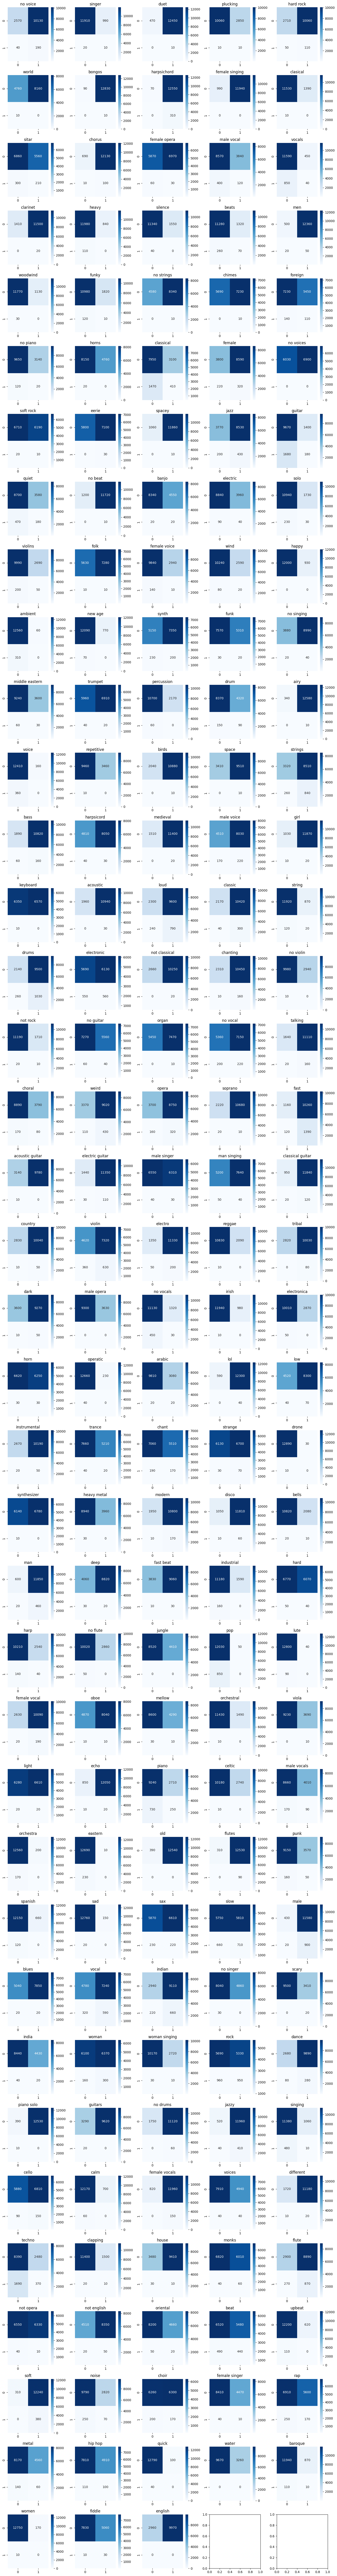

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a grid layout for subplots
num_labels = len(conf_matrix_val)
rows = int(np.ceil(num_labels / 5))  # Adjust the number of rows based on the number of labels
cols = 5  # You can adjust the number of columns as needed
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

# Flatten the axes array to iterate over subplots
axes = axes.flatten()

# Iterate over each confusion matrix and plot it
for i in range(num_labels):
    label_conf_matrix = conf_matrix_val[i]

    # Replace numeric labels with actual labels from label_names
    label_name = label_names[i] if i < len(label_names) else f'Label {i + 1}'

    sns.heatmap(label_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(label_name)  # Set the title to the actual label name

# Adjust layout
plt.tight_layout()
plt.show()

### Comparing AUC-ROC scores across labels




ROC-AUC Scores:
{'no voice': 0.5142245806230743, 'singer': 0.6282945736434108, 'duet': 0.5181888544891641, 'plucking': 0.6396204492641362, 'hard rock': 0.4498580657791699, 'world': 0.1842105263157895, 'bongos': 0.5034829721362228, 'harpsichord': 0.5027733755942947, 'clasical': 0.44620743034055727, 'sitar': 0.48204982476082214, 'chorus': 0.48145653098851227, 'female opera': 0.39524922118380057, 'male vocal': 0.4606706750139466, 'vocals': 0.5037842024711635, 'clarinet': 0.5546088303640588, 'heavy': 0.4672386895475819, 'silence': 0.43987587276958884, 'beats': 0.5536796536796537, 'men': 0.3765829815596534, 'woodwind': 0.4562015503875969, 'funky': 0.4673677884615384, 'no strings': 0.6772445820433437, 'chimes': 0.7202012383900929, 'foreign': 0.5050946372239747, 'no piano': 0.44867642131129226, 'horns': 0.31564678543764524, 'classical': 0.4687710599788197, 'female': 0.44964577167966996, 'soft rock': 0.4267441860465116, 'eerie': 0.7248062015503876, 'spacey': 0.5410216718266254, 'jazz': 0.49452

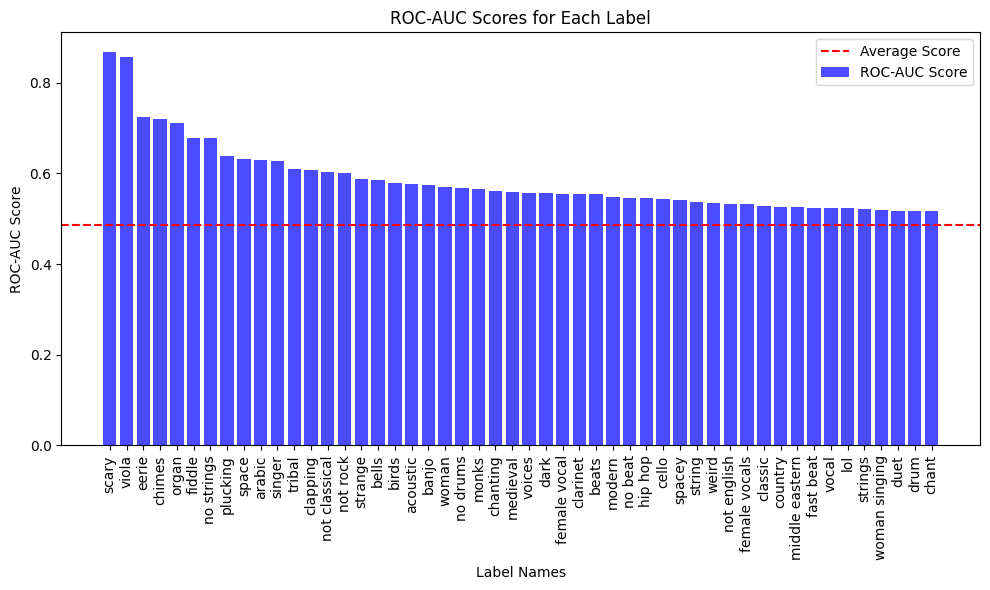

In [ ]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Initialize an empty dictionary to store ROC-AUC scores
roc_auc_scores = {}

# Iterate over class names in the classification report
for class_name in label_names:
    # Extract true labels and predicted probabilities for the current class
    true_labels = val_true[:, label_names.index(class_name)]
    predicted_probs = val_pred[:, label_names.index(class_name)]

    # Check if the class has more than one unique label
    if len(np.unique(true_labels)) > 1:
        # Calculate ROC-AUC score for the current class
        roc_auc = roc_auc_score(true_labels, predicted_probs)
        # Store the ROC-AUC score in the dictionary
        roc_auc_scores[class_name] = roc_auc

# Print the ROC-AUC scores
print("ROC-AUC Scores:")
print(roc_auc_scores)

# Extract labels and scores from the dictionary
labels = list(roc_auc_scores.keys())
scores = list(roc_auc_scores.values())

# Sort labels and scores by descending scores. Top 50 only included.
sorted_indices = np.argsort(scores)[::-1][:50]
sorted_labels = [labels[i] for i in sorted_indices]
sorted_scores = [scores[i] for i in sorted_indices]

# Calculate the average ROC-AUC score
average_score = np.mean(scores)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_labels, sorted_scores, color='blue', alpha=0.7, label='ROC-AUC Score')
plt.axhline(y=average_score, color='red', linestyle='--', label='Average Score')

# Set labels and title
plt.xlabel('Label Names')
plt.ylabel('ROC-AUC Score')
plt.title('ROC-AUC Scores for Each Label')
plt.xticks(rotation=90, ha='center', fontsize=10)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In the context of ROC-AUC scores, the higher the score, the better the model's performance. The horizontal line on the bar chart represents the average ROC-AUC score across all labels. Labels with ROC-AUC scores above this average are considered to be the ones on which the model performed relatively well.

So, by identifying labels above the average score, you're highlighting the specific classes for which the model achieved better-than-average performance in terms of ROC-AUC. These could be considered the "strong suits" of your model in terms of discrimination or classification for the given labels.

### Generating an averaged view of ROC-AUC Scores

{0: array([0.       , 0.7976378, 1.       ]), 1: array([0.        , 0.07674419, 1.        ])}
{0: array([0.        , 0.82608696, 1.        ]), 1: array([0.        , 0.33333333, 1.        ])}
{0: 0.5142245806230743, 1: 0.6282945736434108}


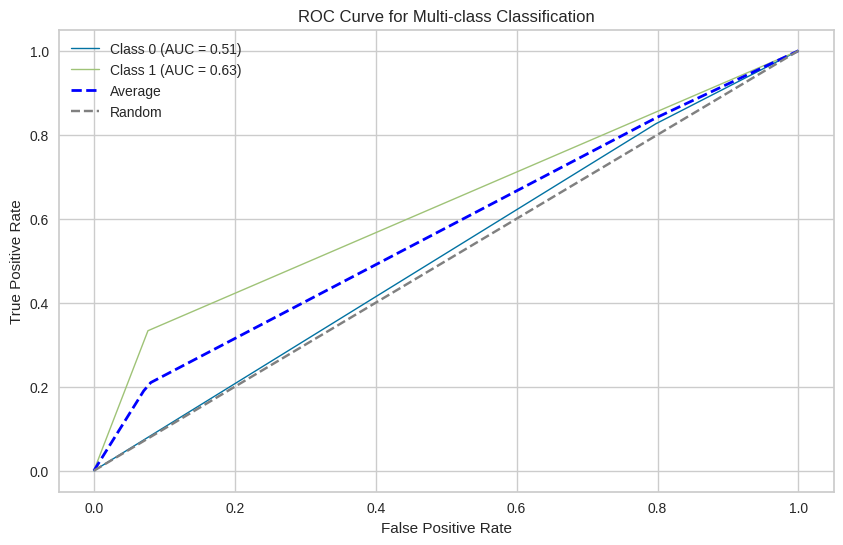

In [ ]:
number_classes = range(0, 2)  # Assuming 2 classes, adjust this number accordingly
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in number_classes:
    fpr[i], tpr[i], _ = roc_curve(val_true[:, i], val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

print(fpr)
print(tpr)
print(roc_auc)
#val_true, val_pred

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(len(fpr)):
    plt.plot(fpr[i], tpr[i], lw=1, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot average ROC curve
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr[i], tpr[i]) for i in range(len(fpr))], axis=0)
plt.plot(mean_fpr, mean_tpr, color='blue', linestyle='--', linewidth=2, label='Average')

# Plot the random guess line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend()
plt.show()

The ROC (Receiver Operating Characteristic) curve is a graphical representation of the performance of a binary classification model at various classification thresholds. It plots the true positive rate (sensitivity) against the false positive rate (1 - specificity) for different threshold values. The AUC (Area Under the Curve) is a metric that quantifies the overall performance of the model across different threshold values. A higher AUC generally indicates better model performance.

In your case, since you have a multi-class classification problem, the ROC curve and AUC are calculated for each class independently. Each line in the plot represents the ROC curve for a specific class, and the AUC value is shown in the legend. The average ROC curve is also plotted, which provides a summary of the overall model performance across all classes.

Key points:

Class-specific ROC Curves: Each line corresponds to a specific class. The curve shows how the model's true positive rate and false positive rate change as you vary the classification threshold.
AUC Scores: The AUC scores (shown in the legend) quantify the area under each ROC curve. Higher AUC values indicate better discrimination between the positive and negative classes.
Average ROC Curve: The dashed blue line represents the average ROC curve across all classes. It summarizes the overall performance of your multi-class model.
Random Guess Line: The gray dashed line represents the ROC curve for random guessing. A model that performs no better than random guessing would have an AUC of 0.5.
By examining the ROC curves and AUC values, you can assess how well your model distinguishes between different classes and make informed decisions about its performance.

### Test Loop - Loss Profile and Overall Evaluation Metrics

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, multilabel_confusion_matrix

#load model
model.load_state_dict(torch.load(model_path))
model.eval()

criterion_test = nn.BCEWithLogitsLoss(pos_weight=test_weights_balanced) #use this loss function since we are doing multilabel classification. pos_weight is the weight to apply to the minority class ('1') in each label column to address class imbalance.
correct_predictions = 0
total_samples = 0
y_pred = []
y_true = []

with torch.no_grad():
    for epoch in range(num_epochs):
        test_loss = 0.0 #initialize validation loss
        for test_batch in test_loader:
            embeddings_test, labels_test = test_batch

            # Forward pass (no optimization in validation)
            test_outputs = model(embeddings_test)

            # Compute validation loss
            loss = criterion_test(test_outputs, labels_test)
            test_loss += loss.item()

            #Convert probabilities to binary predictions using a threshold of 0.5
            predictions = (torch.sigmoid(test_outputs) > 0.5).float()

            #Collect predictions and true labels for precision, recall and F1 score
            y_pred.append(predictions.cpu().numpy())
            y_true.append(labels_test.cpu().numpy())

            #Compute validation accuracy
            correct_predictions += (predictions == labels_test).sum().item()
            total_samples += labels_test.numel()
            #print test loss after each epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Test Loss: {loss.item()}")

# # Calculate average validation loss
# avg_test_loss = test_loss / len(test_loader)

#Concatenate predictions and true labels along the sample axis
y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)

#Calculate overall validation accuracy
test_accuracy = round(((correct_predictions / total_samples)*100), 1)

#Compute precision, recall and F1 score
test_precision = precision_score(y_true, y_pred, average='micro') #micro is used to account for class imbalance
test_recall = recall_score(y_true, y_pred, average='micro') #micro is used to account for class imbalance
test_f1 = f1_score(y_true, y_pred, average='micro') #micro is used to account for class imbalance

#compute confusion matrix for each label

conf_matrix_test = multilabel_confusion_matrix(y_true, y_pred)

# Print validation metrics after each epoch
print(f"Overall Validation Accuracy: {test_accuracy}%, Validation Precision: {test_precision}, Validation Recall: {test_recall}, Validation F1: {test_f1}")

# Compute classification report

data = pd.read_csv('train_5000_example.csv')
label_names = data.columns[:-1].tolist()

test_class_report = classification_report(y_true, y_pred, target_names=label_names, zero_division=1, output_dict=True)

# Print classification report
print("Classification Report:")
print(test_class_report)


Epoch 1/10, Test Loss: 2.351757526397705
Epoch 2/10, Test Loss: 2.351757526397705
Epoch 3/10, Test Loss: 2.351757526397705
Epoch 4/10, Test Loss: 2.351757526397705
Epoch 5/10, Test Loss: 2.351757526397705
Epoch 6/10, Test Loss: 2.351757526397705
Epoch 7/10, Test Loss: 2.351757526397705
Epoch 8/10, Test Loss: 2.351757526397705
Epoch 9/10, Test Loss: 2.351757526397705
Epoch 10/10, Test Loss: 2.351757526397705
Overall Validation Accuracy: 50.9%, Validation Precision: 0.017873055905842792, Validation Recall: 0.4661258495943872, Validation F1: 0.034426083506732194
Classification Report:
{'no voice': {'precision': 0.020246913580246915, 'recall': 0.803921568627451, 'f1-score': 0.039499036608863204, 'support': 510}, 'singer': {'precision': 0.003937007874015748, 'recall': 0.034482758620689655, 'f1-score': 0.007067137809187279, 'support': 290}, 'duet': {'precision': 0.0020729684908789387, 'recall': 1.0, 'f1-score': 0.004137360364087713, 'support': 50}, 'plucking': {'precision': 0.006172839506172

#### Printing and Exporting Evaluation Metrics to further look into latent trends

In [ ]:
# Calculate the average precision, recall, and f1-score
test_avg_precision = sum(test_class_report[label]['precision'] for label in label_names) / len(label_names)
test_avg_recall = sum(test_class_report[label]['recall'] for label in label_names) / len(label_names)
test_avg_f1 = sum(test_class_report[label]['f1-score'] for label in label_names) / len(label_names)

# Identify classes that are above their respective averages
test_above_avg_precision = [label for label in label_names if test_class_report[label]['precision'] > test_avg_precision]
test_above_avg_recall = [label for label in label_names if test_class_report[label]['recall'] > test_avg_recall]
test_above_avg_f1 = [label for label in label_names if test_class_report[label]['f1-score'] > test_avg_f1]

# Create a dictionary with the average values
test_avg_dict = {
    'Metric': ['Precision', 'Recall', 'F1-Score'],
    'Average': [test_avg_precision, test_avg_recall, test_avg_f1]
}

# Create a DataFrame from the average dictionary
test_avg_df = pd.DataFrame(test_avg_dict)

# Print the average DataFrame
print("Average Metrics:")
print(test_avg_df)

# Create a dictionary with the class-specific metrics
test_class_metrics_dict = {
    'Class': label_names,
    'Precision': [test_class_report[label]['precision'] for label in label_names],
    'Recall': [test_class_report[label]['recall'] for label in label_names],
    'F1-Score': [test_class_report[label]['f1-score'] for label in label_names],
    'Support': [test_class_report[label]['support'] for label in label_names]
}

# Create a DataFrame from the class-specific metrics dictionary
test_class_metrics_df = pd.DataFrame(test_class_metrics_dict)

# Print the class-specific metrics DataFrame
print("\nClass-Specific Metrics:")
print(test_class_metrics_df)

# Filter classes based on whether their precision, recall, or f1-score is above average
test_above_avg_precision_df = test_class_metrics_df[test_class_metrics_df['Class'].isin(test_above_avg_precision)]
test_above_avg_recall_df = test_class_metrics_df[test_class_metrics_df['Class'].isin(test_above_avg_recall)]
test_above_avg_f1_df = test_class_metrics_df[test_class_metrics_df['Class'].isin(test_above_avg_f1)]

# Print the filtered DataFrames
print(f"\n {len(test_above_avg_precision_df)} Classes with Precision above Average:")
print(test_above_avg_precision_df)

print(f"\n {len(test_above_avg_recall_df)} Classes with Recall above Average:")
print(test_above_avg_recall_df)

print(f"\n {len(test_above_avg_f1_df)} Classes with F1 above Average:")
print(test_above_avg_f1_df)

# Export DataFrames to Excel
excel_file_path = 'test_metrics_summary.xlsx'
with pd.ExcelWriter(excel_file_path, engine='xlsxwriter') as writer:
    # Write DataFrames to separate tabs
    test_avg_df.to_excel(writer, sheet_name='Average Metrics', index=False)
    test_class_metrics_df.to_excel(writer, sheet_name='Class-Specific Metrics', index=False)
    test_above_avg_precision_df.to_excel(writer, sheet_name='Above Avg Precision', index=False)
    test_above_avg_recall_df.to_excel(writer, sheet_name='Above Avg Recall', index=False)
    test_above_avg_f1_df.to_excel(writer, sheet_name='Above Avg F1', index=False)

print(f"DataFrames exported to {excel_file_path}")


Average Metrics:
      Metric   Average
0  Precision  0.018469
1     Recall  0.511139
2   F1-Score  0.029212

Class-Specific Metrics:
         Class  Precision    Recall  F1-Score  Support
0     no voice   0.020247  0.803922  0.039499      510
1       singer   0.003937  0.034483  0.007067      290
2         duet   0.002073  1.000000  0.004137       50
3     plucking   0.006173  0.176471  0.011928      170
4    hard rock   0.005641  0.733333  0.011196      150
..         ...        ...       ...       ...      ...
183      water   0.001575  0.333333  0.003135       30
184    baroque   0.000000  0.000000  0.000000       20
185      women   0.000000  0.000000  0.000000       60
186     fiddle   0.001936  1.000000  0.003865       20
187    english   0.002552  0.714286  0.005086       70

[188 rows x 5 columns]

 44 Classes with Precision above Average:
           Class  Precision    Recall  F1-Score  Support
0       no voice   0.020247  0.803922  0.039499      510
10         sitar   0.0817

### Generate a single view of all 188 test confusion matrices

In [ ]:
# Create a grid layout for subplots
num_labels = len(conf_matrix_test)
rows = int(np.ceil(num_labels / 5))  # Adjust the number of rows based on the number of labels
cols = 5  # You can adjust the number of columns as needed
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

# Flatten the axes array to iterate over subplots
axes = axes.flatten()

# Iterate over each confusion matrix and plot it
for i in range(num_labels):
    label_conf_matrix = conf_matrix_test[i]

    # Replace numeric labels with actual labels from label_names
    label_name = label_names[i] if i < len(label_names) else f'Label {i + 1}'

    sns.heatmap(label_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(label_name)  # Set the title to the actual label name

# Adjust layout
plt.tight_layout()
plt.show()

#### Comparing AUC-ROC across labels (top 50)

ROC-AUC Scores:
{'no voice': 0.5106392852999189, 'singer': 0.467769341766348, 'duet': 0.5337078651685394, 'plucking': 0.4942298445263664, 'hard rock': 0.4895760404511863, 'world': 0.5768016396166842, 'bongos': 0.5025174283501161, 'harpsichord': 0.47506468527465484, 'female singing': 0.5607350096711798, 'clasical': 0.6913699690402476, 'sitar': 0.4915041871393765, 'chorus': 0.49958993705533794, 'female opera': 0.6075581395348837, 'male vocal': 0.5228226977498115, 'vocals': 0.4919248869331378, 'heavy': 0.5216588966588966, 'silence': 0.502004915276161, 'beats': 0.5169122628158264, 'men': 0.5160728117738187, 'woodwind': 0.5227404965089216, 'funky': 0.5039360872954014, 'no strings': 0.6697638404955478, 'chimes': 0.46691176470588236, 'foreign': 0.5306640625, 'no piano': 0.44393662016286844, 'horns': 0.3135396518375242, 'classical': 0.4758119530132109, 'female': 0.49675136944613507, 'no voices': 0.7524234199302056, 'soft rock': 0.5701863354037268, 'eerie': 0.2468085106382979, 'spacey': 0.55344

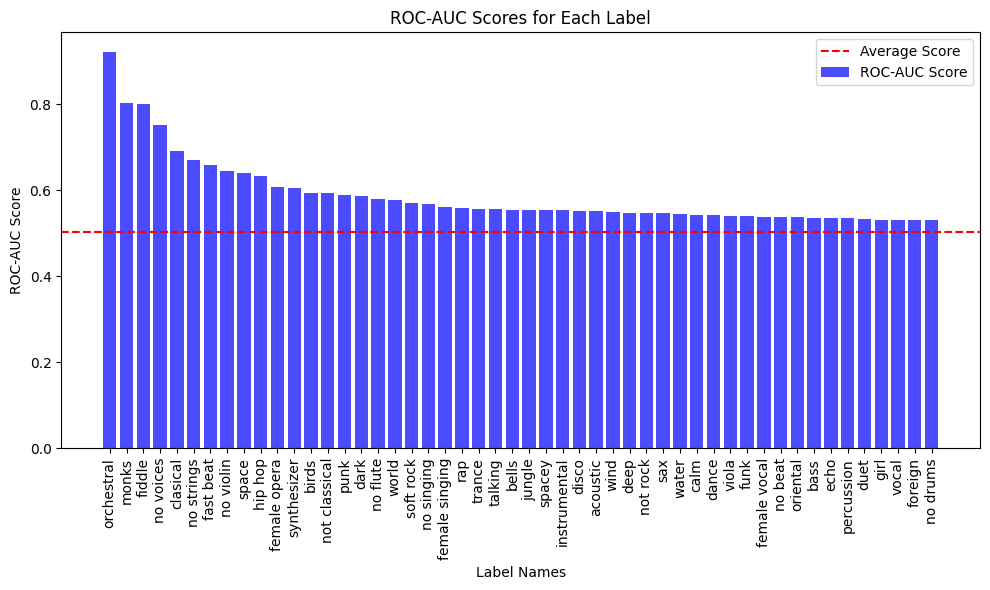

In [ ]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Initialize an empty dictionary to store ROC-AUC scores
test_roc_auc_scores = {}

# Iterate over class names in the classification report
for class_name in label_names:
    # Extract true labels and predicted probabilities for the current class
    test_true_labels = y_true[:, label_names.index(class_name)]
    test_predicted_probs = y_pred[:, label_names.index(class_name)]

    # Check if the class has more than one unique label
    if len(np.unique(test_true_labels)) > 1:
        # Calculate ROC-AUC score for the current class
        test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
        # Store the ROC-AUC score in the dictionary
        test_roc_auc_scores[class_name] = test_roc_auc

# Print the ROC-AUC scores
print("ROC-AUC Scores:")
print(test_roc_auc_scores)

# Extract labels and scores from the dictionary
test_labels = list(test_roc_auc_scores.keys())
test_scores = list(test_roc_auc_scores.values())

# Sort labels and scores by descending scores. Top 50 only included.
test_sorted_indices = np.argsort(test_scores)[::-1][:50]
test_sorted_labels = [test_labels[i] for i in test_sorted_indices]
test_sorted_scores = [test_scores[i] for i in test_sorted_indices]

# Calculate the average ROC-AUC score
test_average_score = np.mean(test_scores)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(test_sorted_labels, test_sorted_scores, color='blue', alpha=0.7, label='ROC-AUC Score')
plt.axhline(y=test_average_score, color='red', linestyle='--', label='Average Score')

# Set labels and title
plt.xlabel('Label Names')
plt.ylabel('ROC-AUC Score')
plt.title('ROC-AUC Scores for Each Label')
plt.xticks(rotation=90, ha='center', fontsize=10)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

If certain labels have a recall of 1 but low precision and F1 scores, it indicates that the model is capturing all the positive instances for those labels but is also predicting many false positives, leading to a decrease in precision and F1 score.
Here's a breakdown of these metrics:
* 		Recall (Sensitivity): The model is correctly identifying all true positive instances for those labels, which is why recall is 1.
* 		Precision: Precision is the ratio of true positives to the total number of predicted positives. If precision is low, it means that a significant portion of the predicted positive instances are false positives.
* 		F1 Score: The F1 score is the harmonic mean of precision and recall. It's low when either precision or recall is low.

In summary, the model is effective at identifying all positive instances for those labels (high recall), but it comes at the cost of a high number of false positives, leading to low precision and F1 score. This suggests that the model may be too aggressive in predicting positive instances for these specific labels. Depending on the application and the importance of precision, you might want to fine-tune the model or adjust the decision threshold to trade off between precision and recall.

## Code Graveyard: Enter at your own peril

## Alternative Model Architectures

In [ ]:
# class CustomAudioModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.5):
#         super(CustomAudioModel, self).__init__()

#         # Define custom feed-forward layers
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.dropout = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(hidden_size, num_classes)
#         #self.softmax = nn.Softmax(dim=1)

#     def forward(self, embeddings):
#     # Apply custom feed-forward layers directly to the input_values
#         x = self.fc1(embeddings)
#         x = F.relu(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         #x = self.softmax(x)

#         #remove extra dimension
#         x = x.squeeze(1)

#         return x


# class CustomAudioModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.5):
#         super(CustomAudioModel, self).__init__()

#         # Define convolutional layers
#         self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)

#         # Define pooling layer
#         self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

#         # Calculate the size of the flattened output after convolution and pooling
#         conv_output_size = input_size // 8 * 128

#         # Define fully connected layers
#         self.fc1 = nn.Linear(conv_output_size, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, num_classes)

#         # Define dropout layer
#         self.dropout = nn.Dropout(dropout_rate)

#     def forward(self, x):
#         # Add a channel dimension to the input
#         # x = x.unsqueeze(1)

#         # Apply convolutional and pooling layers
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))

#         # Flatten the output for fully connected layers
#         x = x.view(x.size(0), -1)

#         # Apply fully connected layers with dropout
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)

#         return x

# class CustomAudioModel(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_classes, dropout_rate=0.5):
#         super(CustomAudioModel, self).__init__()

#         # Define convolutional layers
#         self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)

#         # Define pooling layer
#         self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

#         # Calculate the size of the flattened output after convolution and pooling
#         conv_output_size = input_size // 4 * 128

#         # Define fully connected layers
#         self.fc1 = nn.Linear(conv_output_size, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, output_size)
#         self.fc3 = nn.Linear(output_size, num_classes)

#         # Define dropout layer
#         self.dropout = nn.Dropout(dropout_rate)

#     def forward(self, x):
#         # Add a channel dimension to the input
#         # x = x.unsqueeze(1)

#         # Apply convolutional and pooling layers
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))

#         # Flatten the output for fully connected layers
#         x = x.view(x.size(0), -1)

#         # Apply fully connected layers with dropout
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = F.relu(self.fc2(x))
#         x = self.dropout(x)
#         x = self.fc3(x)

#         return x

# Update if we want to make it deeper etc.

# ## Simple model for GridSearch
#   class SimpleModel(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, dropout_rate):
#         super(SimpleModel, self).__init__()

#         self.fc1 = nn.Linear(input_size, output_size)
#         self.fc2 = nn.Linear(output_size, num_classes)
#         self.dropout = nn.Dropout(dropout_rate)

#     def forward(self, embeddings):
#         x = self.fc1(embeddings)
#         x = F.relu(x)
#         x = self.dropout(x)

#         x = self.fc2(x)

#         # Remove extra dimension
#         x = x.squeeze(1)

#         return x

In [ ]:
# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader
# import librosa
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder
# from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

# # model = Wav2Vec2ForCTC.from_pretrained('OthmaneJ/distil-wav2vec2')
# # processor = Wav2Vec2Processor.from_pretrained('OthmaneJ/distil-wav2vec2')

# #import wav2vec model and processor
# model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base")
# processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

# class CustomAudioDataset(Dataset):
#     def __init__(self, csv_path, processor):
#         self.dataframe = pd.read_csv(csv_path)
#         self.processor = processor

#         # Extract column names for labels dynamically
#         self.label_columns = list(self.dataframe.columns[:-1])  #Exclude first two columns since these are irrelevant

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):

#         # Get the audio path
#         audio_path = self.dataframe.iloc[idx]['mp3_path']

#         # Select label columns based on the dynamically created list. This is grabbing all 188 class label names and converting to tensors.
#         #labels = self.dataframe.iloc[idx][self.label_columns]
#         labels_array = self.dataframe.iloc[idx].loc[self.label_columns].astype('float').values
#         labels = torch.tensor(labels_array, dtype=torch.float32)
#         #labels = torch.tensor(self.dataframe.iloc[idx].loc[self.label_columns].astype('float').values, dtype=torch.float32)

#         # Load raw audio data using librosa
#         audio_data, _ = librosa.load(audio_path, sr=16000, mono=True, res_type="kaiser_fast")

#         #Use processor to process audio file and return tensor of input values for model
#         input_tensors = self.processor(audio_data, return_tensors="pt", sampling_rate=16000).input_values

#         return input_tensors, labels

#     # Define collate_fn to handle the varying lengths of audio files and labels. This will help with batching.
#     def collate_fn(self, batch):
#         input_tensors_batch, labels_batch = zip(*batch)
#         return torch.stack(input_tensors_batch), torch.stack(labels_batch)

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:381: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['lm_head.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'lm_head.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

### Creating Custom Datasets for Train/Validate, Instantiating DataLoaders for Batching, Capturing Input_Size

In [ ]:
# #set the correct paths to the csv files
# csv_path_train = 'train_5000_example.csv'
# csv_path_val = 'valid_example.csv'
# csv_path_test = 'test_example.csv'

# #initialize datasets
# train_example = CustomAudioDataset(csv_path=csv_path_train, processor=processor)
# val_example = CustomAudioDataset(csv_path=csv_path_val, processor=processor)
# test_example = CustomAudioDataset(csv_path=csv_path_test, processor=processor)

# #set the batch size for all dataloaders
# batch_size = 64

# #Dataloader for training
# train_loader = DataLoader(train_example, batch_size=batch_size, shuffle=True, collate_fn=train_example.collate_fn)

# #Dataloader for validation
# val_loader = DataLoader(val_example, batch_size=batch_size, shuffle=False, collate_fn=val_example.collate_fn)

# #Dataloader for testing
# test_loader = DataLoader(test_example, batch_size=batch_size, shuffle=False, collate_fn=test_example.collate_fn)

# #get the size of the audio embeddings
# input_size = train_example[0][0].shape[1] #make sure that we can easily modify embedding size input to model

# #Check the size of the datasets and the audio embeddings
# print(f'We have {len(train_example)} training examples and {len(val_example)} validation examples.')
# print(f'We have {len(train_loader)} batches in the training set and {len(val_loader)} batches in the validation set.')
# print(f'The size of our audio embeddings is {input_size}.')

We have 5000 training examples and 1293 validation examples.
We have 79 batches in the training set and 21 batches in the validation set.
The size of our audio embeddings is 465984.


### Preparing batched training data for parameter grid_search

In [ ]:
# # Initialize empty lists to gather X_train and y_train
# X_train = []
# y_train = []

# # Iterate over the DataLoader to gather all training data
# for batch_input, batch_labels in train_loader:
#     X_train.append(batch_input)
#     y_train.append(batch_labels)

# # Concatenate the lists to create tensors
# X_train = torch.cat(X_train, dim=0)
# y_train = torch.cat(y_train, dim=0)

# # Convert PyTorch tensors to NumPy arrays
# # X_train_numpy = X_train.numpy()
# # y_train_numpy = y_train.numpy()

# #check length of X_train and y_train
# print(f'X_train has {len(X_train)} audio embeddings.')
# print(f'y_train has {len(y_train)} labels and {y_train.shape[1]} classes.')

# Initialize empty lists to gather X_train and y_train
# X_train_batches = []
# y_train_batches = []

# # Iterate over the DataLoader to gather all training data
# for batch_input, batch_labels in train_loader:
#     X_train_batches.append(batch_input)
#     y_train_batches.append(batch_labels)

# # Concatenate the lists to create tensors
# X_train = torch.cat(X_train_batches, dim=0)
# y_train = torch.cat(y_train_batches, dim=0)

# # Check the length of X_train and y_train
# print(f'X_train has {len(X_train)} audio embeddings.')
# print(f'y_train has {len(y_train)} labels and {y_train.shape[1]} classes.')


X_train has 5000 audio embeddings.
y_train has 5000 labels and 188 classes.


In [ ]:
# import torch
# import numpy as np

# # Convert PyTorch tensors to NumPy arrays
# X_train_numpy = X_train.numpy()
# y_train_numpy = y_train.numpy()

# # Get the number of samples you want (e.g., 500)
# num_samples = 50

# # Generate random indices
# random_indices = np.random.choice(len(X_train_numpy), size=num_samples, replace=False)

# # Select random samples
# X_train_sampled = torch.from_numpy(X_train_numpy[random_indices])
# y_train_sampled = torch.from_numpy(y_train_numpy[random_indices])

# # Check the length of sampled X_train and y_train
# print(f'X_train_sampled has {len(X_train_sampled)} audio embeddings.')
# print(f'y_train_sampled has {len(y_train_sampled)} labels and {y_train_sampled.shape[1]} classes.')


X_train_sampled has 50 audio embeddings.
y_train_sampled has 50 labels and 188 classes.


### Initialize Model, specify hyperparameters, train the model and print the loss

In [ ]:
# from skorch import NeuralNetClassifier
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import loguniform
# import torch.nn as nn
# from skorch.callbacks import EarlyStopping

# #define hyperparameters grid or distribution

# num_classes = 188 #number of classes is 188
# weight_decay = .01 #weight decay is .01
# lr = .01 #learning rate is .01
# dropout_rate= 0.5 #dropout rate is 0.5
# hidden_size= 300 #hidden size is 512
# output_size= 200 #output size is half of hidden size
# criterion_train = nn.BCEWithLogitsLoss(pos_weight=train_weights_balanced)  #use BCEWithLogitsLoss with class weights for training
# #optimizer = optim.Adam(model.parameters(), lr=.01, weight_decay=weight_decay) #use Adam optimizer with learning rate of .01, and L2 regularization with weight decay of 1e-5
# num_epochs = 5

# def create_optimizer(module, lr, weight_decay):
#     return optim.Adam(module.parameters(), lr=lr, weight_decay=weight_decay)

# #Early stopping to help with speeding up training
# early_stopping = EarlyStopping(
#     monitor='valid_loss',
#     lower_is_better=True,
#     patience=5,
#     threshold=0.0001,
# )

# model = CustomAudioModel(input_size, hidden_size=hidden_size, output_size=output_size, num_classes=num_classes, dropout_rate=dropout_rate)

# skorch_model = NeuralNetClassifier(
#     model,
#     criterion=criterion_train,
#     max_epochs=num_epochs,
#     module__input_size=input_size,
#     module__hidden_size=hidden_size,
#     module__output_size=output_size,
#     module__num_classes=num_classes,
#     module__dropout_rate=dropout_rate,
#     optimizer=create_optimizer(module=model, lr=lr, weight_decay=weight_decay),
#     iterator_train__shuffle=True,
#     iterator_train__num_workers=8,
#     verbose=0,
#     callbacks=[early_stopping],
#     callbacks__disable=None
# )

# param_dist = {
#     'lr': loguniform(1e-4, 1e-1),
#     'module__hidden_size': [256, 512],
#     'module__dropout_rate': [0.3, 0.5, 0.7],
# }

# random_search = RandomizedSearchCV(
#     skorch_model,
#     param_distributions=param_dist,
#     n_iter=3,
#     scoring='average_precision', #use average precision as the scoring metric
#     cv=3,
#     n_jobs=-1,
# )

# # Fit the RandomizedSearchCV
# random_search.fit(X_train_sampled, y_train_sampled)  # Provide your training data here

# # Print the best parameters and corresponding score
# print("Best Parameters: ", random_search.best_params_)
# print("Best Score: ", random_search.best_score_)

In [ ]:

# csv_path_test = 'test_example.csv'
# test_example = CustomAudioDataset(csv_path=csv_path_test, processor=processor)
# test_loader = DataLoader(test_example, batch_size=8, shuffle=False, collate_fn=test_example.collate_fn)

# #load model
# model.load_state_dict(torch.load(model_path))
# model.eval()

# #initialize lists to store labels and predictions

# y_true = []
# y_pred = []

# with torch.no_grad():
#     for batch in test_loader:
#         embeddings_test, labels_test = batch

#         # Forward pass (no optimization in validation)
#         test_outputs = model(embeddings_test)

#         # Compute test loss
#         test_loss = criterion(test_outputs, labels_test)

#         # Convert predictions to binary (0 or 1)
#         predicted_labels = (test_outputs > 0.5).float()

#         # Print predicted labels
#         all_predictions.append(predicted_labels.numpy())
#         print("Predicted Labels:")
#         print(predicted_labels.numpy())

#         # Print true labels
#         all_labels.append(labels_test.numpy())
#         print("True Labels:")
#         print(labels_test.numpy())

#         #get predictions
#         preds = torch.round(test_outputs)

#         #store predictions and labels for later use
#         y_true.extend(labels_test)
#         y_pred.extend(preds)

# #print loss and accuracy

# print(f"Test Loss: {test_loss.item()}")

Test Loss: 1.289325475692749


### Training with Loop

In [ ]:
# import torch
# import torch.optim as Adam
# import torch.nn as nn

# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = AudioTaggingModel(input_size, 188)

# criterion = nn.BCELoss()
# optimizer = Adam.Adam(model.parameters(), lr=.001)

# num_epochs = 5
# for epoch in range(num_epochs):
#     model.train()
#     for embeddings, labels in train_example:
# #         embeddings, labels = embeddings.to(device), labels.to(device)
#         outputs = model(embeddings).flatten()
#         loss = criterion(outputs, labels)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/5, Loss: 2.5397284030914307
Epoch 2/5, Loss: 3.7234041690826416
Epoch 3/5, Loss: 3.7234041690826416
Epoch 4/5, Loss: 3.7234041690826416
Epoch 5/5, Loss: 3.7234041690826416


### Model Evaluation with Validate Data

In [ ]:
# model.eval()
# val_loss = 0.0
# with torch.no_grad():
#     for embeddings_val, labels_val in val_example:
# #         embeddings_val, labels_val = embeddings_val.to(device), labels_val.to(device)

#         # Forward pass (no optimization in validation)
#         outputs_val = model(embeddings_val).flatten()

#         # Compute validation loss
#         loss_val = criterion(outputs_val, labels_val)
#         val_loss += loss_val.item()

# model_path = "./model_path"
# torch.save(model.state_dict(), model_path)
# # Calculate average validation loss
# avg_val_loss = val_loss / len(val_example)

# # Print training and validation loss after each epoch
# print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {avg_val_loss}")

Epoch 5/5, Training Loss: 3.7234041690826416, Validation Loss: 1.064193355422467


### Load and Test Model Performance on Test Data

In [ ]:
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader
# from sklearn.metrics import precision_score, recall_score, classification_report


# csv_path_test = 'test_example.csv'
# test_example = CustomAudioDataset(csv_path=csv_path_test, processor=processor)
# # Assuming you have test_loader defined


# # Assuming you have already trained and saved your model
# # If not, load your pre-trained model here
# model = AudioTaggingModel(465984, 188)
# model_path = "./model_path"
# model.load_state_dict(torch.load(model_path))
# model.eval()

# # Define your criterion (loss function)
# criterion = nn.BCELoss()

# # Test
# test_loss = 0.0
# all_predictions = []
# all_labels = []

# with torch.no_grad():
#     for embeddings_test, labels_test in test_example:
# #         inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)

#         # Forward pass
#         outputs_test = model(embeddings_test).flatten()

#         # Compute test loss
#         loss_test = criterion(outputs_test, labels_test)
#         test_loss += loss_test.item()

#         # Convert predictions to binary (0 or 1)
#         predicted_labels = (outputs_test > 0.5).float()

#         # Print predicted labels
#         all_predictions.append(predicted_labels.numpy())
#         print("Predicted Labels:")
#         print(predicted_labels.numpy())

#         # Print true labels
#         all_labels.append(labels_test.numpy())
#         print("True Labels:")
#         print(labels_test.numpy())

# # Calculate average test loss
# avg_test_loss = test_loss / len(test_example)

# print(f"Test Loss: {avg_test_loss}")

# all_predictions = np.array(all_predictions)
# all_labels = np.array(all_labels)

# # Convert probabilities to binary predictions
# binary_preds = np.argmax(all_preds, axis=1)
# binary_labels = np.argmax(all_labels, axis=1)

# # Print classification report
# print("Classification Report:")
# print(classification_report(binary_labels, binary_preds))


Predicted Labels:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True Labels:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

Predicted Labels:
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True Labels:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

Predicted Labels:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True Labels:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

Predicted Labels:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
True Labels:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

Predicted Labels:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True Labels:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

NameError: name 'all_preds' is not defined

### Model Graveyard

In [ ]:
# import torch
# import torch.nn as nn
# class CustomAudioModel(nn.Module):
#     def __init__(self, ff_output_size, dataset, ff_input_size=input_size):
#         super(CustomAudioModel, self).__init__()

#         self.dataset = dataset

#         # Define custom feed-forward layers
#         self.fc1 = nn.Linear(ff_input_size*len(self.dataset), ff_output_size)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(ff_output_size, num_classes)
#         #self.sigmoid = nn.Sigmoid()

#     def forward(self, embeddings, labels=None):
#         # Apply custom feed-forward layers directly to the input_values
#         #embeddings = torch.cat([batch['embeddings'] for batch in train_example], dim=1) #concatenate the embeddings
# #         embeddings = self.dataset['embeddings']
#         print("Input Shape:", embeddings.shape)

#         embeddings = embeddings.view(embeddings.size(0), -1) #flatten the embeddings
#         x = self.fc1(embeddings)
#         x = self.relu(x)
#         x = self.fc2(x)

#         if labels is not None:
#             # Calculate the loss if labels are provided
#             # Assuming you are using binary cross-entropy loss
#             loss_fn = nn.BCEWithLogitsLoss()
#             loss = loss_fn(x, labels)
#             return loss
#         else:
#             return x

# import torch
# import torch.nn as nn

# class AudioTaggingModel(nn.Module):
#     def __init__(self, ff_embedding_size, ff_output_size):
#         super(AudioTaggingModel, self).__init__()
#         self.fc1 = nn.Linear(ff_embedding_size, 512)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(512, ff_output_size)
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, embeddings):
#         embeddings = self.fc1(embeddings)
#         embeddings = self.relu(embeddings)
#         embeddings = self.fc2(embeddings)
#         embeddings = self.softmax(embeddings)
#         return embeddings

# class AudioTaggingModel(nn.Module):
#     def __init__(self, ff_embedding_size, ff_output_size):
#         super(AudioTaggingModel, self).__init__()
#         self.fc1 = nn.Linear(ff_embedding_size, 512)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(512, ff_output_size)
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, embeddings):
#         embeddings = self.fc1(embeddings)
#         embeddings = self.relu(embeddings)
#         embeddings = self.fc2(embeddings)
#         embeddings = self.softmax(embeddings)
#         return embeddings

# import torch.nn as nn

# class CustomAudioModel(nn.Module):
#     def __init__(self, input_size=768, hidden_size=64, num_classes=188):
#         super(CustomAudioModel, self).__init__()

#         self.fc = nn.Linear(465984, hidden_size)
#         self.relu = nn.ReLU()
#         self.fc_output = nn.Linear(hidden_size, num_classes)

#     def forward(self, embeddings):

#         x = self.fc(embeddings)
#         x = self.relu(x)
#         x = self.fc_output(x)
#         return x

# # class CustomAudioModel(nn.Module):
# #     def __init__(self, dataset, ff_input_size=embedding_size, ff_output_size=64, num_classes=188):
# #         super(CustomAudioModel, self).__init__()

# #         self.dataset = dataset

# #         # Define custom feed-forward layers
# #         self.fc1 = nn.Linear(ff_input_size, ff_output_size)
# #         self.relu = nn.ReLU()
# #         self.fc2 = nn.Linear(ff_output_size, num_classes)

# #     def forward(self, embeddings):

# #         embeddings = self.dataset['embeddings']  # Grab the audio embeddings from the inputs dictionary
# #         # Flatten the embeddings
# #         embeddings = embeddings.view(embeddings.size(0), -1)

# #         # Apply custom feed-forward layers directly to the flattened embeddings
# #         x = self.fc1(embeddings)
# #         x = self.relu(x)
# #         x = self.fc2(x)

# #         return x

# #     from transformers import Trainer, TrainingArguments
# # from torch.optim import Adam
# # import torch.nn.functional as F
# # #%pip install "transformers[torch]"

# # Instantiate the model
# #model = CustomAudioModel(ff_input_size=embedding_size, ff_output_size=64, num_classes=188)

# # # #These need to be updated
# # # csv_path_train = 'data.csv'
# # # csv_path_val = 'data.csv'

# # # #Creating train and validate datasets
# # # train_dataset = CustomAudioDataset(csv_path_train, processor)
# # # val_dataset = CustomAudioDataset(csv_path_val, processor)

# # # Loss function for multi-label classification
# # # def compute_loss(model, inputs):
# # #     # Your custom loss calculation goes here
# # #     logits = model(inputs['input'])
# # #     loss = F.binary_cross_entropy_with_logits(logits, inputs['labels']) #appropiate loss function for multi-label classification
# # #     return loss

# # #Loss function for binary, multi-label classification

# # #loss_fn = nn.BCEWithLogitsLoss() #appropiate loss function for multi-label classification where each label is binary.

# # # Optimizer
# # optimizer = Adam(model.parameters(), lr=.001)

# # Training arguments -- these need to be adjusted
# # training_args = TrainingArguments(
# #     output_dir='./results',                     # output directory
# #     num_train_epochs=3,                         # total number of training epochs
# #     per_device_train_batch_size=32,             # batch size per device during training
# #     per_device_eval_batch_size=32,              # batch size per device during eval
# #     #weight_decay=0.01,                         # regularization parameter
# #     logging_dir='./logs',                       # directory for storing logs
# #     logging_steps=10,                           # number of steps before logging
# #     evaluation_strategy="steps",                # evaluate every eval_steps
# #     eval_steps=50,                              # number of steps before evaluating
# #     save_total_limit=2,                         # limit the total amount of checkpoints. Deletes the older checkpoints.
# #     save_steps=500,                             # number of updates steps before checkpoint saves
# # )

# # # Trainer instance
# # trainer = Trainer(
# #     model=model,
# #     args=training_args,
# #     train_dataset=train_example,
# #     eval_dataset=val_example,
# #     #compute_loss=loss_fn,
# #     #optimizer=optimizer
# # )

# # # Train the model
# # trainer.train()

In [ ]:
# import librosa

# # Replace 'path_to_your_audio_file.wav' with the path to one of your audio files
# #audio_path = 'train/aba_structure-epic-01-deep_step-291-320.wav'
# audio_path = 'train/aba_structure-epic-01-deep_step-320-349.wav'

# try:
#     audio_data, _ = librosa.load(audio_path, sr=16000)
#     print("Successfully loaded audio file.")
# except Exception as e:
#     print(f"Error loading audio file: {e}")


Successfully loaded audio file.


In [ ]:
# from transformers import Trainer, TrainingArguments
# from torch.optim import Adam
# import torch.nn.functional as F
# #%pip install "transformers[torch]"

# # Instantiate the model
# # model = CustomAudioModel(dataset = train_example, ff_input_size=embedding_size, ff_output_size=64, num_classes=188)
# model = AudioTaggingModel(465984, 188)
# # #These need to be updated
# # csv_path_train = 'data.csv'
# # csv_path_val = 'data.csv'

# # #Creating train and validate datasets
# # train_dataset = CustomAudioDataset(csv_path_train, processor)
# # val_dataset = CustomAudioDataset(csv_path_val, processor)

# # Loss function for multi-label classification
# # def compute_loss(model, inputs):
# #     # Your custom loss calculation goes here
# #     logits = model(inputs['input'])
# #     loss = F.binary_cross_entropy_with_logits(logits, inputs['labels']) #appropiate loss function for multi-label classification
# #     return loss

# #Loss function for binary, multi-label classification
# class CustomTrainer(Trainer):
#     loss_fn = nn.BCEWithLogitsLoss() #appropiate loss function for multi-label classification where each label is binary.

#     # Optimizer
#     optimizer = Adam(model.parameters(), lr=.001)

# # Training arguments -- these need to be adjusted
# training_args = TrainingArguments(
#     output_dir='./results',                     # output directory
#     num_train_epochs=3,                         # total number of training epochs
#     per_device_train_batch_size=5,             # batch size per device during training
#     per_device_eval_batch_size=5,              # batch size per device during eval
#     #weight_decay=0.01,                         # regularization parameter
#     logging_dir='./logs',                       # directory for storing logs
#     logging_steps=10,                           # number of steps before logging
#     evaluation_strategy="steps",                # evaluate every eval_steps
#     eval_steps=50,                              # number of steps before evaluating
#     save_total_limit=2,                         # limit the total amount of checkpoints. Deletes the older checkpoints.
#     save_steps=500,                             # number of updates steps before checkpoint saves
# )

# # Trainer instance
# trainer = CustomTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_example,
#     eval_dataset=val_example,
# #     compute_loss=loss_fn,
#     #optimizer=optimizer
# )

# # Train the model
# trainer.train()

# # Save the model after training
# model_path = "./example_50"
# model.save_pretrained(model_path)
# processor.save_pretrained(model_path)

In [ ]:
# from transformers import Trainer, TrainingArguments
# from torch.optim import Adam
# import torch.nn.functional as F

# # input_size = 768  # Update with the actual size of the embeddings
# # hidden_size = 64  # Adjust based on your architecture
# # num_classes = 188  # Adjust based on the number of classes

# # model = AudioTaggingModel(dataset = train_example, ff_input_size=embedding_size, ff_output_size=64, num_classes=188)

# model = AudioTaggingModel(465984, 188)

# # Set up your training arguments
# training_args = TrainingArguments(
#     output_dir='./results',
#     num_train_epochs=3,
#     per_device_train_batch_size=32,
#     per_device_eval_batch_size=32,
#     save_total_limit=2,
#     save_steps=500,
#     evaluation_strategy="steps",
#     eval_steps=100,
#     learning_rate=2e-5,
# )
# # Instantiate the Trainer
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_example,  # Assuming you have train_example defined
#     eval_dataset=val_example,  # Assuming you have val_example defined
#     data_collator=None,  # You can customize the data collator if needed
#     compute_metrics=None, # You can define your own metrics function if needed
# )

# # Train the model
# trainer.train()

# # Save the model after training
# model_path = "./example_model"
# model.save_pretrained(model_path)

In [ ]:
# class CustomAudioModel(nn.Module):
#     def __init__(self, wav2vec_model_name="facebook/wav2vec2-base-960h", output_size=188, ff_output_size=64):
#         super(CustomAudioModel, self).__init__()

#         # Load the Wav2Vec 2.0 model and processor
#         self.wav2vec_model = AutoModelForCTC.from_pretrained(wav2vec_model_name)
#         self.processor = AutoProcessor.from_pretrained(wav2vec_model_name)

#         # Define custom feed-forward layers
#         self.fc1 = nn.Linear(768, ff_output_size)  # Adjust input size based on Wav2Vec 2.0 model's hidden size
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(ff_output_size, output_size)  # Adjust output size based on your task
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, audio_data):
#         # Process audio data using the Wav2Vec 2.0 model
#         input_tensors = self.processor(audio_data, return_tensors="pt", sampling_rate=16000).input_values
#         with torch.no_grad():
#             embeddings = self.wav2vec_model(input_tensors).last_hidden_state.mean(dim=1)

#         # Apply custom feed-forward layers
#         x = self.fc1(embeddings)
#         x = self.relu(x)
#         x = self.fc2(x)
#         output = self.softmax(x)  # Apply sigmoid activation for multi-label classification

#         return output

#Instantiate the model
# model = CustomAudioModel()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# loss_fn = nn.CrossEntropyLoss()
# num_epochs = 3

# audio_data = torch.randn(1, 16000)  # Replace with your actual audio data
# output = model(audio_data)
# print(output.shape)  # This will be (batch_size, output_size), where output_size is 188 in your case


### Train the model

In [ ]:
# for epoch in range(num_epochs):
#     for batch in data_loader:
#         inputs = batch['input']
#         labels = batch['labels']

#         # Zero the gradients
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model(inputs)

#         # Compute the loss
#         loss = loss_fn(outputs, labels)

#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()

#     print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')


#### Processing the train files

In [ ]:
# import os
# from datasets import load_dataset
# from torch.utils.data import Dataset, DataLoader
# from transformers import AutoProcessor, AutoModelForCTC
# import torch
# import librosa
# import pandas as pd

# # Load your dataset from the CSV file
# csv_path = 'path/to/your/csv/file.csv'
# df = pd.read_csv(csv_path)

# # Load pretrained model and processor
# model = AutoModelForCTC.from_pretrained("facebook/wav2vec2-base-960h")
# processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")

# class CustomAudioDataset(Dataset):
#     def __init__(self, dataframe, processor):
#         self.dataframe = dataframe
#         self.processor = processor

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         audio_path = self.dataframe.iloc[idx]['audio_file']
#         labels = self.dataframe.iloc[idx]['labels']

#         # Load audio file and process using the Wav2Vec processor
#         audio_data, _ = librosa.load(audio_path, sr=16000)
#         input_tensors = self.processor(audio_data, return_tensors="pt", sampling_rate=16000).input_values

#         return {'input': input_tensors, 'labels': torch.tensor(labels, dtype=torch.float32)}

# # Create an instance of your custom dataset
# audio_dataset = CustomAudioDataset(df, processor)

# # Create a PyTorch DataLoader for batching and shuffling
# batch_size = 32  # Adjust as needed
# data_loader = DataLoader(audio_dataset, batch_size=batch_size, shuffle=True)

# # Example usage in a training loop
# for batch in data_loader:
#     inputs = batch['input']
#     labels = batch['labels']

    # Forward pass, loss calculation, backward pass, optimization, etc.
    # Your training code goes here


In [ ]:
# #Path to the directory containing the audio files
# train_audio = 'train'

# #list all files in the directory
# audio_files = [os.path.join(train_audio, file) for file in os.listdir(train_audio)]

# #Define number of files to process
# num_files = 10

# #iterate over audio file and extract embeddings.

# for i, audio_file in enumerate(audio_files):
#   embeddings = extract_audio_embeddings(audio_file)

#   #save embeddings in a numpy array
#   if i == 0:
#     embeddings_array = embeddings
#   else:
#     embeddings_array = np.vstack((embeddings_array, embeddings))

#   #Check if number of files to process has been reached
#   if i + 1 == num_files:
#     print(f'Processed {num_files} files. Stopping the iteration.')
#     break